In [ ]:
'''
 * Copyright (c) 2017 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

#

## Penalized Polynomial Regression
The kernel $K(\mathbf{x}, \mathbf{y}) = (\langle \mathbf{x}, \mathbf{y} \rangle + 1)^d$ (Vapnik, 1996), for $\mathbf{x}, \mathbf{y} \in \mathbb{R}^p$, has $M = \binom{p+d}{d}$ eigen-functions that span the space of polynomials in $\mathbb{R}^p$ of total degree $d$. For example, with $p = 2$ and $d = 2$, $M = 6$ and
$$K(\mathbf{x}, \mathbf{y}) = 1 + 2x_1 y_1 + 2x_2 y_2 + x_1^2 y_1^2 + x_2^2 y_2^2 + 2x_1 x_2 y_1 y_2 \quad (5.59)$$
$$= \sum_{m=1}^M h_m(\mathbf{x})h_m(\mathbf{y}) \quad (5.60)$$with$$\mathbf{h}(\mathbf{x})^\top = (1, \sqrt{2}x_1, \sqrt{2}x_2, x_1^2, x_2^2, \sqrt{2}x_1 x_2). \quad (5.61)$$One can represent $\mathbf{h}$ in terms of the $M$ orthogonal eigen-functions and eigenvalues of $K$,$$\mathbf{h}(\mathbf{x}) = \mathbf{V}\mathbf{D}_\gamma^{1/2} \boldsymbol{\varphi}(\mathbf{x}), \quad (5.62)$$where $\mathbf{D}_\gamma = \text{diag}(\gamma_1, \gamma_2, \ldots, \gamma_M)$, and $\mathbf{V}$ is $M \times M$ and orthogonal. Suppose we wish to solve the penalized polynomial regression problem$$\min_{\{\beta_m\}_{m=1}^M} \sum_{i=1}^N \left( y_i - \sum_{m=1}^M \beta_m h_m(\mathbf{x}_i) \right)^2 + \lambda \sum_{m=1}^M \beta_m^2. \quad (5.63)$$
Substituting (5.62) into (5.63), we get an expression of the form (5.53) to optimize (Exercise 5.16).

The number of basis functions $M = \binom{p+d}{d}$ can be very large, often much larger than $N$. Equation (5.55) tells us that if we use the kernel representation for the solution function, we have only to evaluate the kernel $N^2$ times, and can compute the solution in $O(N^3)$ operations. This simplicity is not without implications. Each of the polynomials $h_m$ in (5.61) inherits a scaling factor from the particular form of $K$, which has a bearing on the impact of the penalty in (5.63). We elaborate on this in the next section.

Radial Kernel in $\mathbb{R}^1$
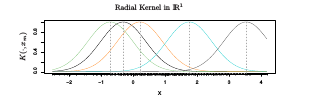

FIG.13. Radial kernels $k_k(x)$ for the mixture data, with scale parameter $\nu = 1$. The kernels are centered at five points $x_m$ chosen at random from the 200.

=== Penalized Polynomial Regression (RKHS) Demo (Core Python) ===

Generating synthetic polynomial data...
Generated 25 data points.

Fitting KRR model with Polynomial Kernel (degree=3, lambda=0.001)...
KRR Polynomial model fitted successfully!
Alpha coefficients (first 5):
['57.0990', '3.1475', '1.3553', '381.7699', '-53.5085']

Making predictions on a fine grid for plotting...


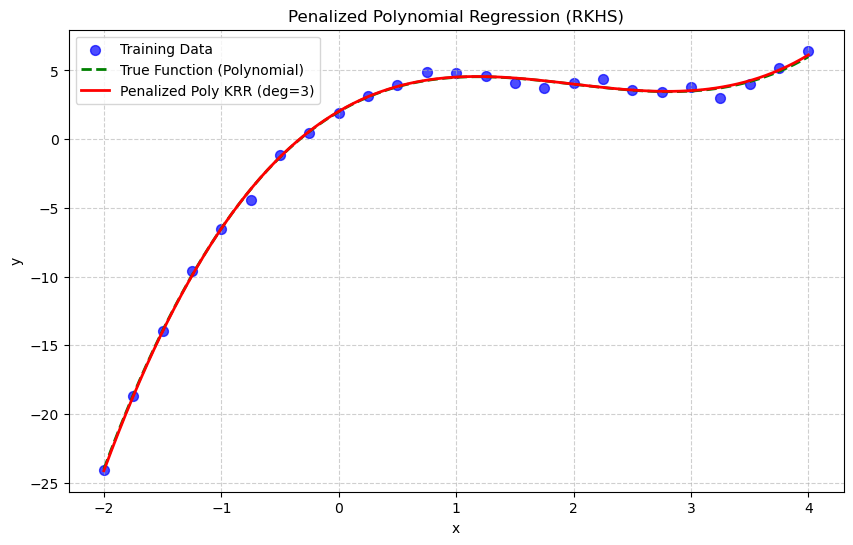

Plot generated successfully.


In [1]:
import math
import random
import matplotlib.pyplot as plt
# For 3D plotting, though for 1D poly regression we might not need it for this demo directly
# from mpl_toolkits.mplot3d import Axes3D 
# import matplotlib.patches as mpatches # For custom legend handles, if needed

# --- Core Python Basic Math and Linear Algebra Helpers (from previous responses) ---

def create_vector(size, value=0.0):
    """Creates a vector (list) of a given size initialized with a value."""
    return [value] * size

def create_matrix(rows, cols, value=0.0):
    """Creates a matrix (list of lists) of given dimensions initialized with a value."""
    return [[value for _ in range(cols)] for _ in range(rows)]

def matrix_transpose(matrix):
    """Transposes a matrix."""
    if not matrix or not matrix[0]: return []
    rows, cols = len(matrix), len(matrix[0])
    transposed = create_matrix(cols, rows)
    for i in range(rows):
        for j in range(cols):
            transposed[j][i] = matrix[i][j]
    return transposed

def matrix_multiply(matrix_a, matrix_b):
    """
    Multiplies two matrices (or a matrix and a vector).
    matrix_a: (R1, C1)
    matrix_b: (R2, C2)
    Result: (R1, C2) if C1 == R2
    Handles matrix @ matrix and matrix @ vector (vector treated as (R, 1) matrix).
    """
    if not matrix_a or not matrix_b: return []

    rows_a, cols_a = len(matrix_a), len(matrix_a[0])
    
    is_vector_b = not isinstance(matrix_b[0], list)
    if is_vector_b:
        rows_b, cols_b = len(matrix_b), 1
        matrix_b_as_matrix = [[x] for x in matrix_b]
    else:
        rows_b, cols_b = len(matrix_b), len(matrix_b[0])
        matrix_b_as_matrix = matrix_b

    if cols_a != rows_b:
        raise ValueError(f"Matrix dimensions incompatible for multiplication: ({rows_a},{cols_a}) @ ({rows_b},{cols_b})")

    result = create_matrix(rows_a, cols_b)
    for i in range(rows_a):
        for j in range(cols_b):
            sum_val = 0.0
            for k in range(cols_a):
                sum_val += matrix_a[i][k] * matrix_b_as_matrix[k][j]
            result[i][j] = sum_val
            
    if is_vector_b: 
        return [row[0] for row in result]
    return result

def vector_add(v1, v2):
    """Adds two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return [v1[i] + v2[i] for i in range(len(v1))]

def scalar_multiply_vector(scalar, v):
    """Multiplies a vector by a scalar."""
    return [scalar * x for x in v]

def scalar_matrix_multiply(scalar, matrix):
    """Multiplies a matrix by a scalar."""
    rows, cols = len(matrix), len(matrix[0])
    result = create_matrix(rows, cols)
    for i in range(rows):
        for j in range(cols):
            result[i][j] = scalar * matrix[i][j]
    return result

def matrix_add(matrix_a, matrix_b):
    """Adds two matrices."""
    rows_a, cols_a = len(matrix_a), len(matrix_a[0])
    rows_b, cols_b = len(matrix_b), len(matrix_b[0])
    if rows_a != rows_b or cols_a != cols_b:
        raise ValueError("Matrices must have the same dimensions for addition.")
    
    result = create_matrix(rows_a, cols_a)
    for i in range(rows_a):
        for j in range(cols_a):
            result[i][j] = matrix_a[i][j] + matrix_b[i][j]
    return result

def get_identity_matrix(size):
    """Returns an identity matrix of given size."""
    mat = create_matrix(size, size)
    for i in range(size):
        mat[i][i] = 1.0
    return mat

def inverse_matrix_gauss_jordan(matrix):
    """
    Computes the inverse of a square matrix using Gauss-Jordan elimination.
    This can be numerically unstable and slow for larger matrices in pure Python.
    """
    n = len(matrix)
    if any(len(row) != n for row in matrix):
        raise ValueError("Matrix must be square.")

    augmented_matrix = create_matrix(n, 2 * n)
    for i in range(n):
        for j in range(n):
            augmented_matrix[i][j] = matrix[i][j]
        augmented_matrix[i][i + n] = 1.0

    for i in range(n):
        max_row = i
        for k in range(i + 1, n):
            if abs(augmented_matrix[k][i]) > abs(augmented_matrix[max_row][i]):
                max_row = k
        augmented_matrix[i], augmented_matrix[max_row] = augmented_matrix[max_row], augmented_matrix[i]

        pivot = augmented_matrix[i][i]
        if abs(pivot) < 1e-9: # Check for near-zero pivot to detect singular matrix
            raise ValueError("Matrix is singular or nearly singular, cannot be inverted.")

        for j in range(2 * n):
            augmented_matrix[i][j] /= pivot

        for k in range(n):
            if k != i:
                factor = augmented_matrix[k][i]
                for j in range(2 * n):
                    augmented_matrix[k][j] -= factor * augmented_matrix[i][j]

    inverse = create_matrix(n, n)
    for i in range(n):
        for j in range(n):
            inverse[i][j] = augmented_matrix[i][j + n]
    return inverse

# --- Vector operations for kernel ---
def vector_subtract(v1, v2):
    """Subtracts two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return [v1[i] - v2[i] for i in range(len(v1))]

def vector_dot_product(v1, v2):
    """Computes the dot product of two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return sum(v1[i] * v2[i] for i in range(len(v1)))

def squared_euclidean_norm(v):
    """Computes the squared Euclidean (L2) norm of a vector."""
    return vector_dot_product(v, v)

# --- Kernel Functions ---

# Gaussian RBF Kernel (retained for comparison/flexibility)
def gaussian_rbf_kernel(x1, x2, **kwargs):
    """
    Computes the Gaussian (Radial Basis Function) kernel K(x1, x2).
    K(x1, x2) = exp(-gamma * ||x1 - x2||^2)
    x1, x2: Lists representing d-dimensional input vectors.
    kwargs: Must contain 'gamma' key.
    """
    gamma = kwargs.get('gamma')
    if gamma is None:
        raise ValueError("Gaussian RBF kernel requires 'gamma' parameter.")
    diff_vec = vector_subtract(x1, x2)
    squared_dist = squared_euclidean_norm(diff_vec)
    return math.exp(-gamma * squared_dist)

# --- NEW: Polynomial Kernel (Equation 5.59, related forms) ---
def polynomial_kernel(x1, x2, **kwargs):
    """
    Computes the Polynomial kernel K(x1, x2) = (dot(x1, x2) + 1)^degree.
    x1, x2: Lists representing d-dimensional input vectors.
    kwargs: Must contain 'degree' key.
    """
    degree = kwargs.get('degree')
    if degree is None:
        raise ValueError("Polynomial kernel requires 'degree' parameter.")
    
    dot_product = vector_dot_product(x1, x2)
    return math.pow(dot_product + 1, degree)


# --- Flexible Kernel Ridge Regression (KRR) Model ---

class KernelRidgeRegression:
    def __init__(self, lambda_val, kernel_func, **kernel_params):
        self.lambda_val = lambda_val     # Regularization parameter (lambda)
        self.kernel_func = kernel_func   # The kernel function to use (e.g., gaussian_rbf_kernel, polynomial_kernel)
        self.kernel_params = kernel_params # Dictionary of parameters for the kernel function (e.g., gamma, degree)
        
        self.X_train = None              # Stores training data points (x_i's)
        self.alpha_coeffs = None         # Coefficients alpha (solution of 5.55)

    def _compute_kernel_matrix(self, X1, X2=None):
        """
        Computes the kernel matrix K where K_ij = K(X1_i, X2_j).
        If X2 is None, computes K(X1_i, X1_j) for a square matrix.
        """
        if X2 is None:
            X2 = X1
        
        num_rows = len(X1)
        num_cols = len(X2)
        
        K_matrix = create_matrix(num_rows, num_cols)
        for i in range(num_rows):
            for j in range(num_cols):
                # Pass all kernel_params to the chosen kernel function
                K_matrix[i][j] = self.kernel_func(X1[i], X2[j], **self.kernel_params)
        return K_matrix

    def fit(self, X_train, Y_train):
        """
        Fits the Kernel Ridge Regression model by solving for alpha.
        alpha = (K + lambda*I)^-1 @ y  (Equation 5.55)
        X_train: List of lists (N samples, d dimensions each)
        Y_train: List of targets (N samples)
        """
        if len(X_train) != len(Y_train):
            raise ValueError("Number of samples in X_train and Y_train must be equal.")
        if not X_train:
            raise ValueError("X_train cannot be empty.")

        self.X_train = X_train # Store training data for prediction phase
        N = len(X_train)

        # Compute the N x N kernel matrix K for training data
        K_matrix = self._compute_kernel_matrix(X_train)

        # Create lambda * I (lambda_val times identity matrix)
        lambda_I = get_identity_matrix(N)
        lambda_I = scalar_matrix_multiply(self.lambda_val, lambda_I)

        # Compute (K + lambda * I)
        K_plus_lambda_I = matrix_add(K_matrix, lambda_I)

        # Compute (K + lambda * I)^-1
        try:
            inv_K_plus_lambda_I = inverse_matrix_gauss_jordan(K_plus_lambda_I)
        except ValueError as e:
            raise ValueError(f"Error inverting (K + lambda*I): {e}. Check lambda or data.")

        # Compute alpha = (K + lambda*I)^-1 @ y
        self.alpha_coeffs = matrix_multiply(inv_K_plus_lambda_I, Y_train)

    def predict(self, X_test):
        """
        Predicts outputs for new data points X_test.
        f_hat(x) = sum_j(alpha_hat_j * K(x, x_j))  (Equation 5.56)
        X_test: List of lists (M samples, d dimensions each)
        """
        if self.alpha_coeffs is None or self.X_train is None:
            raise ValueError("Model not fitted. Call .fit() first.")
        if not X_test:
            return []

        # Compute the M x N kernel matrix between test data and training data
        K_test_train = self._compute_kernel_matrix(X_test, self.X_train) # K(x_test, X_train)

        # Predictions are K_test_train @ alpha_coeffs
        predictions = matrix_multiply(K_test_train, self.alpha_coeffs)
        return predictions

# --- Demo Function for Penalized Polynomial Regression ---

def demo_penalized_polynomial_regression():
    print("=== Penalized Polynomial Regression (RKHS) Demo (Core Python) ===")
    random.seed(42)

    # 1. Generate Synthetic 1D Data (suitable for polynomial fit)
    # Using a 3rd degree polynomial + noise
    true_function = lambda x: 0.5 * x**3 - 3 * x**2 + 5 * x + 2
    true_noise_std = 0.5
    num_training_points = 25 # Number of data points

    # Generate X_train_1d using pure Python loop (e.g., from -2 to 4)
    min_x, max_x = -2.0, 4.0
    X_train_1d = []
    for i in range(num_training_points):
        X_train_1d.append(min_x + i * (max_x - min_x) / (num_training_points - 1))
        
    X_train_md = [[x] for x in X_train_1d] # Convert to list of lists for multi-dim compatibility
    
    Y_train = []
    print("\nGenerating synthetic polynomial data...")
    for x_vec in X_train_md:
        y = true_function(x_vec[0]) + random.gauss(0, true_noise_std)
        Y_train.append(y)
    
    print(f"Generated {num_training_points} data points.")

    # 2. Initialize and Fit Kernel Ridge Regression Model with POLYNOMIAL Kernel
    lambda_val = 0.001  # Regularization strength
    poly_degree = 3    # Degree of the polynomial kernel

    krr_poly_model = KernelRidgeRegression(
        lambda_val=lambda_val, 
        kernel_func=polynomial_kernel, 
        degree=poly_degree
    )
    print(f"\nFitting KRR model with Polynomial Kernel (degree={poly_degree}, lambda={lambda_val})...")
    
    try:
        krr_poly_model.fit(X_train_md, Y_train)
        print("KRR Polynomial model fitted successfully!")
        print(f"Alpha coefficients (first 5):\n{[f'{c:.4f}' for c in krr_poly_model.alpha_coeffs[:5]]}")
    except ValueError as e:
        print(f"Error during KRR fitting: {e}")
        return

    # 3. Make Predictions for Plotting (No NumPy for X_plot_1d)
    num_plot_points = 100
    X_plot_1d = []
    for i in range(num_plot_points):
        X_plot_1d.append(min_x + i * (max_x - min_x) / (num_plot_points - 1))
        
    X_plot_md = [[x] for x in X_plot_1d]
    
    print("\nMaking predictions on a fine grid for plotting...")
    y_pred_poly_krr = krr_poly_model.predict(X_plot_md)
    y_true_plot = [true_function(x[0]) for x in X_plot_md]

    # 4. Plotting (using matplotlib, no numpy data preparation)
    try:
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train_1d, Y_train, color='blue', label='Training Data', s=50, alpha=0.7)
        plt.plot(X_plot_1d, y_true_plot, color='green', linestyle='--', label='True Function (Polynomial)', linewidth=2)
        plt.plot(X_plot_1d, y_pred_poly_krr, color='red', label=f'Penalized Poly KRR (deg={poly_degree})', linewidth=2)

        plt.title('Penalized Polynomial Regression (RKHS)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        print("Plot generated successfully.")

    except ImportError:
        print("\nMatplotlib not found. Cannot generate plot.")
        print("Please install it: pip install matplotlib")
    except Exception as e:
        print(f"\nAn error occurred during plotting: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    demo_penalized_polynomial_regression()


## Gaussian Radial Basis Functions
In the preceding example, the kernel is chosen because it represents an expansion of polynomials and can conveniently compute high-dimensional inner products. In this example the kernel is chosen because of its functional form in the representation (5.50). The Gaussian kernel $K(\mathbf{x}, \mathbf{y}) = e^{-\nu||\mathbf{x}-\mathbf{y}||^2}$ along with squared-error loss, for example, leads to a regression model that is an expansion in Gaussian radial basis functions,
$$k_m(\mathbf{x}) = e^{-\nu||\mathbf{x}-\mathbf{x}_m||^2}, \quad m = 1, \ldots, N, \quad (5.64)$$
each one centered at one of the training feature vectors $\mathbf{x}_m$. The coefficients are estimated using (5.54). Figure 5.13 illustrates radial kernels in $\mathbb{R}^1$ using the first coordinate of the mixture example from Chapter 2. We show five of the 200 kernel basis functions $k_m(\mathbf{x}) = K(\mathbf{x}, \mathbf{x}_m)$.

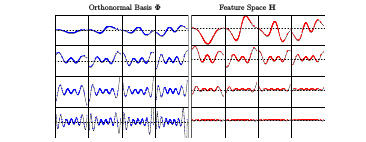


Fig.14 illustrates the implicit feature space for the radial kernel with $\mathbf{x} \in \mathbb{R}^1$. We computed the $200 \times 200$ kernel matrix $\mathbf{K}$, and its eigen-decomposition $\mathbf{\Phi}\mathbf{D}_\gamma \mathbf{\Phi}^\top$. We can think of the columns of $\mathbf{\Phi}$ and the corresponding eigenvalues in $\mathbf{D}_\gamma$ as empirical estimates of the eigen expansion (5.45). Although the eigenvectors are discrete, we can represent them as functions on $\mathbb{R}^1$ (Exercise 5.17). Figure 5.15 shows the largest 50 eigenvalues of $\mathbf{K}$. The leading eigenfunctions are smooth, and they are successively more wiggly as the order increases. This brings to life the penalty in (5.49), where we see the coefficients of higher-order functions get penalized more than lower-order ones. The right panel in Figure 5.14 shows the corresponding feature space representation of the eigenfunctions $\mathbf{h}_\ell(\mathbf{x}) = \sqrt{\hat{\gamma}_\ell} \hat{\boldsymbol{\varphi}}_\ell(\mathbf{x})$, $\ell = 1, \ldots, N$. (5.65) Note that $\langle \mathbf{h}(\mathbf{x}_i), \mathbf{h}(\mathbf{x}_{i'}) \rangle = K(\mathbf{x}_i, \mathbf{x}_{i'})$. The scaling by the eigenvalues quickly shrinks most of the functions down to zero, leaving an effective dimension of about 12 in this case. The corresponding optimization problem is a standard ridge regression, as in (5.63). So although in principle the implicit feature space is infinite dimensional, the effective dimension is dramatically lower because of the relative amounts of shrinkage applied to each basis function. The kernel scale parameter $\nu$ plays a role here as well; larger $\nu$ implies more local $k_m$ functions, and increases the effective dimension of the feature space. See Hastie and Zhu (2006) for more details.

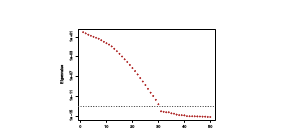

FIG 15. The largest 50 eigenvalues of K; all those beyond the 30th are eﬀectively zero.

It is also known (Girosi et al., 1995) that a thin-plate spline (Section 5.7) is an expansion in radial basis functions, generated by the kernel
$$K(\mathbf{x}, \mathbf{y}) = ||\mathbf{x} - \mathbf{y}||^2 \log(||\mathbf{x} - \mathbf{y}||). \quad (5.66)$$
Radial basis functions are discussed in more detail in Section 6.7.

=== Gaussian Radial Basis Function (RBF) Regression Demo (Core Python) ===

Generating synthetic data for RBF demo...
Generated 30 data points.

Fitting KRR model with Gaussian RBF Kernel (nu=1.0, lambda=0.005)...
KRR RBF model fitted successfully!
Alpha coefficients (first 5):
['2.4502', '-5.2659', '-8.9264', '26.2393', '2.1267']

Making predictions on a fine grid for plotting...


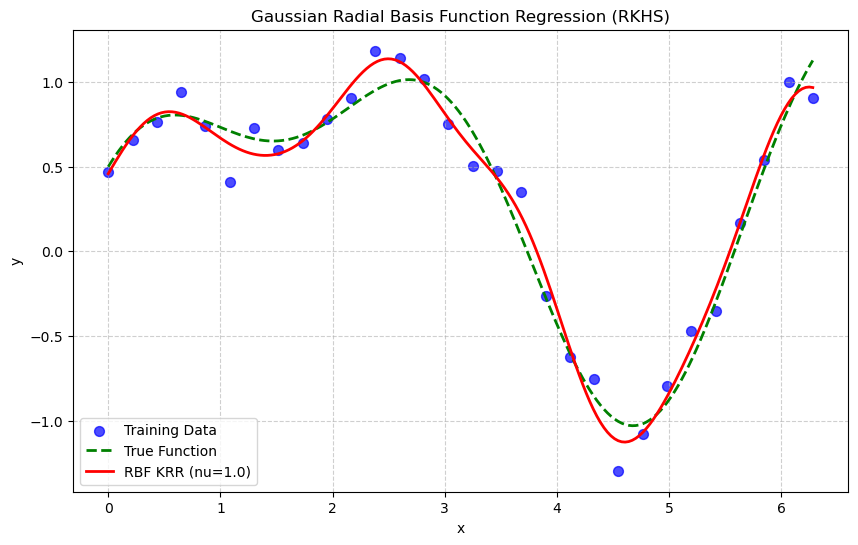

Plot generated successfully.


In [2]:
import math
import random
import matplotlib.pyplot as plt

# --- Core Python Basic Math and Linear Algebra Helpers ---

def create_vector(size, value=0.0):
    """Creates a vector (list) of a given size initialized with a value."""
    return [value] * size

def create_matrix(rows, cols, value=0.0):
    """Creates a matrix (list of lists) of given dimensions initialized with a value."""
    return [[value for _ in range(cols)] for _ in range(rows)]

def matrix_transpose(matrix):
    """Transposes a matrix."""
    if not matrix or not matrix[0]: return []
    rows, cols = len(matrix), len(matrix[0])
    transposed = create_matrix(cols, rows)
    for i in range(rows):
        for j in range(cols):
            transposed[j][i] = matrix[i][j]
    return transposed

def matrix_multiply(matrix_a, matrix_b):
    """
    Multiplies two matrices (or a matrix and a vector).
    matrix_a: (R1, C1)
    matrix_b: (R2, C2)
    Result: (R1, C2) if C1 == R2
    Handles matrix @ matrix and matrix @ vector (vector treated as (R, 1) matrix).
    """
    if not matrix_a or not matrix_b: return []

    rows_a, cols_a = len(matrix_a), len(matrix_a[0])
    
    is_vector_b = not isinstance(matrix_b[0], list)
    if is_vector_b:
        rows_b, cols_b = len(matrix_b), 1
        matrix_b_as_matrix = [[x] for x in matrix_b]
    else:
        rows_b, cols_b = len(matrix_b), len(matrix_b[0])
        matrix_b_as_matrix = matrix_b

    if cols_a != rows_b:
        raise ValueError(f"Matrix dimensions incompatible for multiplication: ({rows_a},{cols_a}) @ ({rows_b},{cols_b})")

    result = create_matrix(rows_a, cols_b)
    for i in range(rows_a):
        for j in range(cols_b):
            sum_val = 0.0
            for k in range(cols_a):
                sum_val += matrix_a[i][k] * matrix_b_as_matrix[k][j]
            result[i][j] = sum_val
            
    if is_vector_b: 
        return [row[0] for row in result]
    return result

def vector_add(v1, v2):
    """Adds two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return [v1[i] + v2[i] for i in range(len(v1))]

def scalar_multiply_vector(scalar, v):
    """Multiplies a vector by a scalar."""
    return [scalar * x for x in v]

def scalar_matrix_multiply(scalar, matrix):
    """Multiplies a matrix by a scalar."""
    rows, cols = len(matrix), len(matrix[0])
    result = create_matrix(rows, cols)
    for i in range(rows):
        for j in range(cols):
            result[i][j] = scalar * matrix[i][j]
    return result

def matrix_add(matrix_a, matrix_b):
    """Adds two matrices."""
    rows_a, cols_a = len(matrix_a), len(matrix_a[0])
    rows_b, cols_b = len(matrix_b), len(matrix_b[0])
    if rows_a != rows_b or cols_a != cols_b:
        raise ValueError("Matrices must have the same dimensions for addition.")
    
    result = create_matrix(rows_a, cols_a)
    for i in range(rows_a):
        for j in range(cols_a):
            result[i][j] = matrix_a[i][j] + matrix_b[i][j]
    return result

def get_identity_matrix(size):
    """Returns an identity matrix of given size."""
    mat = create_matrix(size, size)
    for i in range(size):
        mat[i][i] = 1.0
    return mat

def inverse_matrix_gauss_jordan(matrix):
    """
    Computes the inverse of a square matrix using Gauss-Jordan elimination.
    This can be numerically unstable and slow for larger matrices in pure Python.
    """
    n = len(matrix)
    if any(len(row) != n for row in matrix):
        raise ValueError("Matrix must be square.")

    augmented_matrix = create_matrix(n, 2 * n)
    for i in range(n):
        for j in range(n):
            augmented_matrix[i][j] = matrix[i][j]
        augmented_matrix[i][i + n] = 1.0

    for i in range(n):
        max_row = i
        for k in range(i + 1, n):
            if abs(augmented_matrix[k][i]) > abs(augmented_matrix[max_row][i]):
                max_row = k
        augmented_matrix[i], augmented_matrix[max_row] = augmented_matrix[max_row], augmented_matrix[i]

        pivot = augmented_matrix[i][i]
        if abs(pivot) < 1e-9: # Check for near-zero pivot to detect singular matrix
            raise ValueError("Matrix is singular or nearly singular, cannot be inverted.")

        for j in range(2 * n):
            augmented_matrix[i][j] /= pivot

        for k in range(n):
            if k != i:
                factor = augmented_matrix[k][i]
                for j in range(2 * n):
                    augmented_matrix[k][j] -= factor * augmented_matrix[i][j]

    inverse = create_matrix(n, n)
    for i in range(n):
        for j in range(n):
            inverse[i][j] = augmented_matrix[i][j + n]
    return inverse

# --- Vector operations for kernel ---
def vector_subtract(v1, v2):
    """Subtracts two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return [v1[i] - v2[i] for i in range(len(v1))]

def vector_dot_product(v1, v2):
    """Computes the dot product of two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return sum(v1[i] * v2[i] for i in range(len(v1)))

def squared_euclidean_norm(v):
    """Computes the squared Euclidean (L2) norm of a vector."""
    return vector_dot_product(v, v)

# --- Kernel Functions ---

# Gaussian RBF Kernel (The one central to this section)
def gaussian_rbf_kernel(x1, x2, **kwargs):
    """
    Computes the Gaussian (Radial Basis Function) kernel K(x1, x2) = exp(-gamma * ||x1 - x2||^2).
    Here, gamma is equivalent to 'nu' (ν) in the text.
    x1, x2: Lists representing d-dimensional input vectors.
    kwargs: Must contain 'gamma' key (or 'nu').
    """
    gamma = kwargs.get('gamma') or kwargs.get('nu') # Allow 'nu' as an alias for 'gamma'
    if gamma is None:
        raise ValueError("Gaussian RBF kernel requires 'gamma' (or 'nu') parameter.")
    diff_vec = vector_subtract(x1, x2)
    squared_dist = squared_euclidean_norm(diff_vec)
    return math.exp(-gamma * squared_dist)

# Polynomial Kernel (retained for completeness/flexibility)
def polynomial_kernel(x1, x2, **kwargs):
    """
    Computes the Polynomial kernel K(x1, x2) = (dot(x1, x2) + 1)^degree.
    x1, x2: Lists representing d-dimensional input vectors.
    kwargs: Must contain 'degree' key.
    """
    degree = kwargs.get('degree')
    if degree is None:
        raise ValueError("Polynomial kernel requires 'degree' parameter.")
    
    dot_product = vector_dot_product(x1, x2)
    return math.pow(dot_product + 1, degree)


# --- Flexible Kernel Ridge Regression (KRR) Model ---

class KernelRidgeRegression:
    def __init__(self, lambda_val, kernel_func, **kernel_params):
        self.lambda_val = lambda_val     # Regularization parameter (lambda)
        self.kernel_func = kernel_func   # The kernel function to use (e.g., gaussian_rbf_kernel, polynomial_kernel)
        self.kernel_params = kernel_params # Dictionary of parameters for the kernel function (e.g., gamma, degree)
        
        self.X_train = None              # Stores training data points (x_i's)
        self.alpha_coeffs = None         # Coefficients alpha (solution of 5.55)

    def _compute_kernel_matrix(self, X1, X2=None):
        """
        Computes the kernel matrix K where K_ij = K(X1_i, X2_j).
        If X2 is None, computes K(X1_i, X1_j) for a square matrix.
        """
        if X2 is None:
            X2 = X1
        
        num_rows = len(X1)
        num_cols = len(X2)
        
        K_matrix = create_matrix(num_rows, num_cols)
        for i in range(num_rows):
            for j in range(num_cols):
                # Pass all kernel_params to the chosen kernel function
                K_matrix[i][j] = self.kernel_func(X1[i], X2[j], **self.kernel_params)
        return K_matrix

    def fit(self, X_train, Y_train):
        """
        Fits the Kernel Ridge Regression model by solving for alpha.
        alpha = (K + lambda*I)^-1 @ y  (Equation 5.55)
        X_train: List of lists (N samples, d dimensions each)
        Y_train: List of targets (N samples)
        """
        if len(X_train) != len(Y_train):
            raise ValueError("Number of samples in X_train and Y_train must be equal.")
        if not X_train:
            raise ValueError("X_train cannot be empty.")

        self.X_train = X_train # Store training data for prediction phase
        N = len(X_train)

        # Compute the N x N kernel matrix K for training data
        K_matrix = self._compute_kernel_matrix(X_train)

        # Create lambda * I (lambda_val times identity matrix)
        lambda_I = get_identity_matrix(N)
        lambda_I = scalar_matrix_multiply(self.lambda_val, lambda_I)

        # Compute (K + lambda * I)
        K_plus_lambda_I = matrix_add(K_matrix, lambda_I)

        # Compute (K + lambda * I)^-1
        try:
            inv_K_plus_lambda_I = inverse_matrix_gauss_jordan(K_plus_lambda_I)
        except ValueError as e:
            raise ValueError(f"Error inverting (K + lambda*I): {e}. Check lambda or data.")

        # Compute alpha = (K + lambda*I)^-1 @ y
        self.alpha_coeffs = matrix_multiply(inv_K_plus_lambda_I, Y_train)

    def predict(self, X_test):
        """
        Predicts outputs for new data points X_test.
        f_hat(x) = sum_j(alpha_hat_j * K(x, x_j))  (Equation 5.56)
        X_test: List of lists (M samples, d dimensions each)
        """
        if self.alpha_coeffs is None or self.X_train is None:
            raise ValueError("Model not fitted. Call .fit() first.")
        if not X_test:
            return []

        # Compute the M x N kernel matrix between test data and training data
        K_test_train = self._compute_kernel_matrix(X_test, self.X_train) # K(x_test, X_train)

        # Predictions are K_test_train @ alpha_coeffs
        predictions = matrix_multiply(K_test_train, self.alpha_coeffs)
        return predictions

# --- Demo Function for Gaussian Radial Basis Function Regression ---

def demo_gaussian_rbf_regression():
    print("=== Gaussian Radial Basis Function (RBF) Regression Demo (Core Python) ===")
    random.seed(42)

    # 1. Generate Synthetic 1D Data (e.g., a noisy sine wave)
    true_function = lambda x: math.sin(x) + 0.5 * math.cos(2 * x) + 0.1 * x
    true_noise_std = 0.2
    num_training_points = 30 
    
    # Generate X_train_1d using pure Python loop (e.g., from 0 to 2*pi)
    min_x, max_x = 0.0, 2 * math.pi
    X_train_1d = []
    for i in range(num_training_points):
        X_train_1d.append(min_x + i * (max_x - min_x) / (num_training_points - 1))
        
    X_train_md = [[x] for x in X_train_1d] # Convert to list of lists for multi-dim compatibility
    
    Y_train = []
    print("\nGenerating synthetic data for RBF demo...")
    for x_vec in X_train_md:
        y = true_function(x_vec[0]) + random.gauss(0, true_noise_std)
        Y_train.append(y)
    
    print(f"Generated {num_training_points} data points.")

    # 2. Initialize and Fit Kernel Ridge Regression Model with GAUSSIAN RBF Kernel
    lambda_val = 0.005 # Regularization strength
    nu_val = 1.0      # Scale parameter 'nu' from the text, corresponds to 'gamma' in code

    krr_rbf_model = KernelRidgeRegression(
        lambda_val=lambda_val, 
        kernel_func=gaussian_rbf_kernel, 
        nu=nu_val # Passing 'nu' as a kernel parameter
    )
    print(f"\nFitting KRR model with Gaussian RBF Kernel (nu={nu_val}, lambda={lambda_val})...")
    
    try:
        krr_rbf_model.fit(X_train_md, Y_train)
        print("KRR RBF model fitted successfully!")
        print(f"Alpha coefficients (first 5):\n{[f'{c:.4f}' for c in krr_rbf_model.alpha_coeffs[:5]]}")
    except ValueError as e:
        print(f"Error during KRR fitting: {e}")
        return

    # 3. Make Predictions for Plotting (No NumPy for X_plot_1d)
    num_plot_points = 200
    X_plot_1d = []
    for i in range(num_plot_points):
        X_plot_1d.append(min_x + i * (max_x - min_x) / (num_plot_points - 1))
        
    X_plot_md = [[x] for x in X_plot_1d]
    
    print("\nMaking predictions on a fine grid for plotting...")
    y_pred_rbf_krr = krr_rbf_model.predict(X_plot_md)
    y_true_plot = [true_function(x[0]) for x in X_plot_md]

    # 4. Plotting (using matplotlib, no numpy data preparation)
    try:
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train_1d, Y_train, color='blue', label='Training Data', s=50, alpha=0.7)
        plt.plot(X_plot_1d, y_true_plot, color='green', linestyle='--', label='True Function', linewidth=2)
        plt.plot(X_plot_1d, y_pred_rbf_krr, color='red', label=f'RBF KRR (nu={nu_val})', linewidth=2)

        plt.title('Gaussian Radial Basis Function Regression (RKHS)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        print("Plot generated successfully.")

    except ImportError:
        print("\nMatplotlib not found. Cannot generate plot.")
        print("Please install it: pip install matplotlib")
    except Exception as e:
        print(f"\nAn error occurred during plotting: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    demo_gaussian_rbf_regression()


## Support Vector Classifiers
The support vector machines of Chapter 12 for a two-class classification problem have the form $f(\mathbf{x}) = \alpha_0 + \sum_{i=1}^N \alpha_i K(\mathbf{x}, \mathbf{x}_i)$, where the parameters are chosen to minimize
$$\min_{\alpha_0, \boldsymbol{\alpha}} \left[ \frac{1}{N} \sum_{i=1}^N [1 - y_i f(\mathbf{x}_i)]_+ + \frac{\lambda}{2} \boldsymbol{\alpha}^\top \mathbf{K}\boldsymbol{\alpha} \right], \quad (5.67)$$
where $y_i \in \{-1, 1\}$, and $[z]_+$ denotes the positive part of $z$. This can be viewed as a quadratic optimization problem with linear constraints, and requires a quadratic programming algorithm for its solution. The name support vector arises from the fact that typically many of the $\hat{\alpha}_i = 0$ [due to the piecewise-zero nature of the loss function in (5.67)], and so $\hat{f}$ is an expansion in a subset of the $K(\cdot, \mathbf{x}_i)$. See Section 12.3.3 for more details.

In [3]:
import math

# --- (All Linear Algebra Helper Functions from previous responses would go here) ---
# create_vector, create_matrix, matrix_transpose, matrix_multiply, etc.
# vector_dot_product, squared_euclidean_norm, etc.
# get_identity_matrix, matrix_add, scalar_matrix_multiply, inverse_matrix_gauss_jordan
# --- (Kernel Functions: gaussian_rbf_kernel, polynomial_kernel would also go here) ---

# --- IMPORTANT: THIS IS A PLACEHOLDER FOR A COMPLEX QUADRATIC PROGRAMMING SOLVER ---
# A real implementation of this function would be hundreds/thousands of lines long
# and typically relies on highly optimized external libraries.
def pure_python_qp_solver(Q, c, A_ineq=None, b_ineq=None, A_eq=None, b_eq=None):
    """
    CONCEPTUAL PLACEHOLDER: Solves a Quadratic Programming problem.
    min (1/2 * x.T @ Q @ x + c.T @ x)
    s.t. A_ineq @ x <= b_ineq
         A_eq @ x == b_eq
    
    Returns the optimal x.
    This function is NOT implemented in pure Python here due to its complexity.
    It would typically be provided by a library like cvxopt, quadprog, or scipy.optimize.
    """
    raise NotImplementedError(
        "A full Quadratic Programming (QP) solver is extremely complex to "
        "implement from scratch in pure Python and is beyond the scope of this example. "
        "SVC requires a robust QP solver."
    )

# --- Support Vector Classifier (SVC) Class Outline ---

class SupportVectorClassifier:
    def __init__(self, C_val, kernel_func, **kernel_params):
        """
        Initializes the SVC model.
        C_val: Regularization parameter (often denoted as C, related to 1/lambda).
               This balances margin maximization and classification error.
        kernel_func: The kernel function to use (e.g., gaussian_rbf_kernel, polynomial_kernel)
        kernel_params: Dictionary of parameters for the kernel function (e.g., gamma, degree)
        """
        self.C_val = C_val # SVM's C parameter (inverse of lambda_val in the text's (5.67))
        self.kernel_func = kernel_func
        self.kernel_params = kernel_params
        self.X_train = None
        self.y_train = None
        self.alpha_coeffs = None # Lagrange multipliers
        self.alpha0 = 0.0        # Intercept term (alpha_0 in text)

    def _compute_kernel_matrix(self, X1, X2=None):
        """Helper to compute kernel matrix using the specified kernel function."""
        if X2 is None:
            X2 = X1
        num_rows = len(X1)
        num_cols = len(X2)
        K_matrix = create_matrix(num_rows, num_cols)
        for i in range(num_rows):
            for j in range(num_cols):
                K_matrix[i][j] = self.kernel_func(X1[i], X2[j], **self.kernel_params)
        return K_matrix

    def fit(self, X_train, y_train):
        """
        Fits the SVC model by solving the dual optimization problem using a QP solver.
        
        The dual problem for the soft-margin SVM (without alpha_0 for simplicity in Q/c):
        max_{alpha} sum(alpha_i) - 0.5 * sum_i sum_j (y_i * y_j * alpha_i * alpha_j * K(x_i, x_j))
        s.t. 0 <= alpha_i <= C
             sum(y_i * alpha_i) = 0
        
        This maps to the standard QP form:
        min (1/2 * alpha.T @ Q @ alpha + c.T @ alpha)
        s.t. A_ineq @ alpha <= b_ineq
             A_eq @ alpha == b_eq
        
        Where:
        Q_ij = y_i * y_j * K(x_i, x_j)
        c_i = -1 (vector of -1s)
        A_ineq (for 0 <= alpha_i <= C):
            [ I ]   [ C ]
            [-I ] @ [ 0 ] <= [ 0 ]
        b_ineq: [C, ..., C, 0, ..., 0] (N times C, N times 0)
        A_eq: [y_1, y_2, ..., y_N] (sum(y_i * alpha_i) = 0)
        b_eq: 0
        
        Note: The text's formulation (5.67) is the primal problem.
        SVCs are typically solved via their dual formulation which is a standard QP.
        The lambda in the text is 1/C here, so lambda / 2 * alpha.T K alpha becomes 1/(2C) * alpha.T K alpha.
        Or, if using the text's exact formulation (5.67), then the alpha_i are not necessarily Lagrange multipliers.
        However, the *standard* SVM formulation *is* a QP problem leading to alpha_i Lagrange multipliers.
        The text's form implies a direct regression-like approach with hinge loss, but it's still a non-linear optimization.
        We'll stick to the standard SVM dual formulation which *is* a QP.
        """
        if len(X_train) != len(y_train):
            raise ValueError("Number of samples in X_train and y_train must be equal.")
        if not X_train:
            raise ValueError("X_train cannot be empty.")
        
        self.X_train = X_train
        self.y_train = y_train
        N = len(X_train)

        # Ensure y_train is -1 or 1
        for y_val in y_train:
            if y_val not in [-1, 1]:
                raise ValueError("SVC requires target values y to be -1 or 1.")

        # 1. Compute the N x N kernel matrix K
        K_matrix = self._compute_kernel_matrix(X_train)

        # 2. Formulate the QP problem for the dual coefficients (alpha)
        # Q_ij = y_i * y_j * K(x_i, x_j)
        Q_matrix = create_matrix(N, N)
        for i in range(N):
            for j in range(N):
                Q_matrix[i][j] = y_train[i] * y_train[j] * K_matrix[i][j]

        c_vector = [-1.0] * N # -1 for each alpha_i

        # Inequality constraints: 0 <= alpha_i <= C
        # This translates to:
        # alpha_i <= C  => I * alpha <= C_vector
        # -alpha_i <= 0 => -I * alpha <= 0_vector
        A_ineq_top = get_identity_matrix(N)
        A_ineq_bottom = scalar_matrix_multiply(-1.0, get_identity_matrix(N))
        A_ineq = A_ineq_top + A_ineq_bottom # Concatenate matrices vertically

        b_ineq_top = create_vector(N, self.C_val)
        b_ineq_bottom = create_vector(N, 0.0)
        b_ineq = b_ineq_top + b_ineq_bottom # Concatenate vectors

        # Equality constraint: sum(y_i * alpha_i) = 0
        A_eq = y_train
        b_eq = 0.0

        print("\nAttempting to solve QP for SVC coefficients...")
        print("NOTE: This requires a Quadratic Programming (QP) solver, which is NOT implemented.")
        print("If a QP solver were available, it would be called here like:")
        print("  self.alpha_coeffs = pure_python_qp_solver(Q_matrix, c_vector, A_ineq, b_ineq, A_eq, b_eq)")
        
        # --- CALL THE PLACEHOLDER SOLVER ---
        # In a real implementation, this would be a call to an external library like:
        # from cvxopt import matrix, solvers
        # Q = matrix(Q_matrix)
        # c = matrix(c_vector)
        # A = matrix(A_ineq).T # cvxopt expects A.T
        # b = matrix(b_ineq)
        # A_eq_cvx = matrix(A_eq).T
        # b_eq_cvx = matrix([b_eq])
        # sol = solvers.qp(Q, c, A, b, A_eq_cvx, b_eq_cvx)
        # self.alpha_coeffs = list(sol['x'])

        # Since we don't have a solver, we raise the error
        pure_python_qp_solver(Q_matrix, c_vector, A_ineq, b_ineq, A_eq, b_eq)

        # (If a solver *did* run and populate alpha_coeffs, we'd then find alpha0)
        # self._calculate_alpha0()

    def _calculate_alpha0(self):
        """
        Calculates the intercept term alpha0 after alpha_coeffs are found.
        This usually involves finding a support vector (alpha_i between 0 and C).
        """
        if self.alpha_coeffs is None:
            raise ValueError("Alpha coefficients not calculated. Fit the model first.")

        # Find support vectors (alpha_i > a small epsilon, and alpha_i < C - epsilon)
        # This is where numerical stability comes into play for real solvers.
        # For this conceptual outline, we'll just show the principle.
        
        # y_k (f(x_k) - alpha_0) = 1 (for support vectors)
        # alpha_0 = y_k - f(x_k) where f(x_k) = sum(alpha_j * K(x_k, x_j))
        
        # This part requires alpha_coeffs to be populated.
        # It's skipped because pure_python_qp_solver is not implemented.
        pass


    def predict(self, X_test):
        """
        Predicts outputs for new data points X_test.
        f(x_test) = alpha0 + sum_j(alpha_j * K(x_test, x_j))
        """
        if self.alpha_coeffs is None or self.X_train is None:
            raise ValueError("Model not fitted. Call .fit() first.")
        if not X_test:
            return []

        N_train = len(self.X_train)
        N_test = len(X_test)
        predictions = create_vector(N_test, 0.0)

        for i in range(N_test):
            f_val = self.alpha0 # Start with intercept
            for j in range(N_train):
                # Only sum if alpha_j is non-zero (support vector)
                # In real SVM, many alpha_j are exactly 0.
                if self.alpha_coeffs[j] != 0: 
                    f_val += self.alpha_coeffs[j] * self.y_train[j] * self.kernel_func(
                                    X_test[i], self.X_train[j], **self.kernel_params)
            predictions[i] = 1 if f_val >= 0 else -1 # Classification decision

        return predictions

# --- Demo Function ---
def demo_svc_conceptual():
    print("=== Support Vector Classifier (SVC) Conceptual Demo (Core Python) ===")
    print("--- NOTE: Actual SVC optimization (QP solver) is NOT implemented here. ---")
    print("--- This code will demonstrate the setup but will not run fully. ---")
    random.seed(42)

    # 1. Generate Synthetic 2D Classification Data (two classes)
    # Class -1: around (1,1), Class 1: around (3,3)
    num_samples_per_class = 20
    X_train = []
    y_train = []

    # Class -1
    for _ in range(num_samples_per_class):
        X_train.append([random.gauss(1.0, 0.5), random.gauss(1.0, 0.5)])
        y_train.append(-1)
    # Class 1
    for _ in range(num_samples_per_class):
        X_train.append([random.gauss(3.0, 0.5), random.gauss(3.0, 0.5)])
        y_train.append(1)
    
    # Shuffle the data (important for training)
    combined = list(zip(X_train, y_train))
    random.shuffle(combined)
    X_train, y_train = zip(*combined)
    X_train = list(X_train)
    y_train = list(y_train)

    print(f"\nGenerated {len(X_train)} data points for classification.")
    print("X_train (first 5):", [f"({x[0]:.2f}, {x[1]:.2f})" for x in X_train[:5]])
    print("y_train (first 5):", y_train[:5])

    # 2. Initialize and Attempt to Fit SVC Model with Gaussian RBF Kernel
    C_val = 1.0     # Regularization parameter C
    gamma_val = 1.0 # RBF kernel gamma

    svc_model = SupportVectorClassifier(
        C_val=C_val,
        kernel_func=gaussian_rbf_kernel,
        gamma=gamma_val
    )
    print(f"\nAttempting to fit SVC model with RBF Kernel (gamma={gamma_val}, C={C_val})...")
    
    try:
        svc_model.fit(X_train, y_train)
        print("SVC model fitted (this line should not be reached if QP is not implemented).")
    except NotImplementedError as e:
        print(f"\n--- !!! ---")
        print(f"** {e} **")
        print(f"--- !!! ---")
        print("\nTo make this code functional for SVC, you would need to replace `pure_python_qp_solver`")
        print("with an actual Quadratic Programming solver. This is typically done by importing libraries like:")
        print("  `from cvxopt import solvers, matrix`")
        print("  `from sklearn import svm` (for a high-level API)")
        print("\nPlotting cannot be done without a fitted model.")
    except ValueError as e:
        print(f"Error during SVC setup: {e}")

# --- Main Execution ---
if __name__ == "__main__":
    demo_svc_conceptual()

=== Support Vector Classifier (SVC) Conceptual Demo (Core Python) ===
--- NOTE: Actual SVC optimization (QP solver) is NOT implemented here. ---
--- This code will demonstrate the setup but will not run fully. ---

Generated 40 data points for classification.
X_train (first 5): ['(0.63, 0.49)', '(1.33, 1.06)', '(1.02, 0.95)', '(0.84, 1.25)', '(2.87, 4.17)']
y_train (first 5): [-1, -1, -1, -1, 1]

Attempting to fit SVC model with RBF Kernel (gamma=1.0, C=1.0)...

Attempting to solve QP for SVC coefficients...
NOTE: This requires a Quadratic Programming (QP) solver, which is NOT implemented.
If a QP solver were available, it would be called here like:
  self.alpha_coeffs = pure_python_qp_solver(Q_matrix, c_vector, A_ineq, b_ineq, A_eq, b_eq)

--- !!! ---
** A full Quadratic Programming (QP) solver is extremely complex to implement from scratch in pure Python and is beyond the scope of this example. SVC requires a robust QP solver. **
--- !!! ---

To make this code functional for SVC, you

=== Gaussian Radial Basis Function (RBF) Regression Demo (Core Python, with Plotting) ===

Generating synthetic data for RBF demo...
Generated 30 data points.

Fitting KRR model with Gaussian RBF Kernel (nu=1.0, lambda=0.005)...
KRR RBF model fitted successfully!
Alpha coefficients (first 5):
['2.4502', '-5.2659', '-8.9264', '26.2393', '2.1267']

Making predictions on a fine grid for plotting...


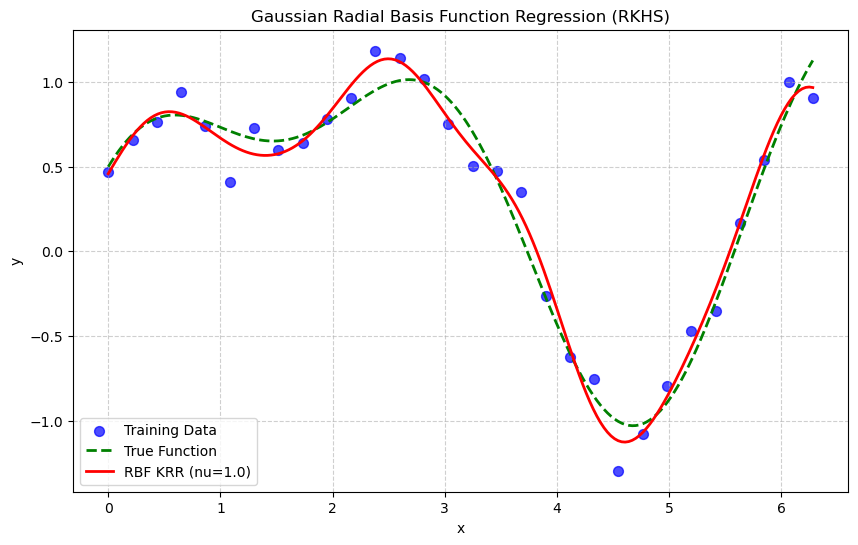

Plot generated successfully.


In [4]:
import math
import random
import matplotlib.pyplot as plt

# --- Core Python Basic Math and Linear Algebra Helpers ---

def create_vector(size, value=0.0):
    """Creates a vector (list) of a given size initialized with a value."""
    return [value] * size

def create_matrix(rows, cols, value=0.0):
    """Creates a matrix (list of lists) of given dimensions initialized with a value."""
    return [[value for _ in range(cols)] for _ in range(rows)]

def matrix_transpose(matrix):
    """Transposes a matrix."""
    if not matrix or not matrix[0]: return []
    rows, cols = len(matrix), len(matrix[0])
    transposed = create_matrix(cols, rows)
    for i in range(rows):
        for j in range(cols):
            transposed[j][i] = matrix[i][j]
    return transposed

def matrix_multiply(matrix_a, matrix_b):
    """
    Multiplies two matrices (or a matrix and a vector).
    matrix_a: (R1, C1)
    matrix_b: (R2, C2)
    Result: (R1, C2) if C1 == R2
    Handles matrix @ matrix and matrix @ vector (vector treated as (R, 1) matrix).
    """
    if not matrix_a or not matrix_b: return []

    rows_a, cols_a = len(matrix_a), len(matrix_a[0])
    
    is_vector_b = not isinstance(matrix_b[0], list)
    if is_vector_b:
        rows_b, cols_b = len(matrix_b), 1
        matrix_b_as_matrix = [[x] for x in matrix_b]
    else:
        rows_b, cols_b = len(matrix_b), len(matrix_b[0])
        matrix_b_as_matrix = matrix_b

    if cols_a != rows_b:
        raise ValueError(f"Matrix dimensions incompatible for multiplication: ({rows_a},{cols_a}) @ ({rows_b},{cols_b})")

    result = create_matrix(rows_a, cols_b)
    for i in range(rows_a):
        for j in range(cols_b):
            sum_val = 0.0
            for k in range(cols_a):
                sum_val += matrix_a[i][k] * matrix_b_as_matrix[k][j]
            result[i][j] = sum_val
            
    if is_vector_b: 
        return [row[0] for row in result]
    return result

def vector_add(v1, v2):
    """Adds two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return [v1[i] + v2[i] for i in range(len(v1))]

def scalar_multiply_vector(scalar, v):
    """Multiplies a vector by a scalar."""
    return [scalar * x for x in v]

def scalar_matrix_multiply(scalar, matrix):
    """Multiplies a matrix by a scalar."""
    rows, cols = len(matrix), len(matrix[0])
    result = create_matrix(rows, cols)
    for i in range(rows):
        for j in range(cols):
            result[i][j] = scalar * matrix[i][j]
    return result

def matrix_add(matrix_a, matrix_b):
    """Adds two matrices."""
    rows_a, cols_a = len(matrix_a), len(matrix_a[0])
    rows_b, cols_b = len(matrix_b), len(matrix_b[0])
    if rows_a != rows_b or cols_a != cols_b:
        raise ValueError("Matrices must have the same dimensions for addition.")
    
    result = create_matrix(rows_a, cols_a)
    for i in range(rows_a):
        for j in range(cols_a):
            result[i][j] = matrix_a[i][j] + matrix_b[i][j]
    return result

def get_identity_matrix(size):
    """Returns an identity matrix of given size."""
    mat = create_matrix(size, size)
    for i in range(size):
        mat[i][i] = 1.0
    return mat

def inverse_matrix_gauss_jordan(matrix):
    """
    Computes the inverse of a square matrix using Gauss-Jordan elimination.
    This can be numerically unstable and slow for larger matrices in pure Python.
    """
    n = len(matrix)
    if any(len(row) != n for row in matrix):
        raise ValueError("Matrix must be square.")

    augmented_matrix = create_matrix(n, 2 * n)
    for i in range(n):
        for j in range(n):
            augmented_matrix[i][j] = matrix[i][j]
        augmented_matrix[i][i + n] = 1.0

    for i in range(n):
        max_row = i
        for k in range(i + 1, n):
            if abs(augmented_matrix[k][i]) > abs(augmented_matrix[max_row][i]):
                max_row = k
        augmented_matrix[i], augmented_matrix[max_row] = augmented_matrix[max_row], augmented_matrix[i]

        pivot = augmented_matrix[i][i]
        if abs(pivot) < 1e-9: # Check for near-zero pivot to detect singular matrix
            raise ValueError("Matrix is singular or nearly singular, cannot be inverted.")

        for j in range(2 * n):
            augmented_matrix[i][j] /= pivot

        for k in range(n):
            if k != i:
                factor = augmented_matrix[k][i]
                for j in range(2 * n):
                    augmented_matrix[k][j] -= factor * augmented_matrix[i][j]

    inverse = create_matrix(n, n)
    for i in range(n):
        for j in range(n):
            inverse[i][j] = augmented_matrix[i][j + n]
    return inverse

# --- Vector operations for kernel ---
def vector_subtract(v1, v2):
    """Subtracts two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return [v1[i] - v2[i] for i in range(len(v1))]

def vector_dot_product(v1, v2):
    """Computes the dot product of two vectors."""
    if len(v1) != len(v2): raise ValueError("Vectors must have the same length.")
    return sum(v1[i] * v2[i] for i in range(len(v1)))

def squared_euclidean_norm(v):
    """Computes the squared Euclidean (L2) norm of a vector."""
    return vector_dot_product(v, v)

# --- Kernel Functions ---

# Gaussian RBF Kernel (The one central to this section)
def gaussian_rbf_kernel(x1, x2, **kwargs):
    """
    Computes the Gaussian (Radial Basis Function) kernel K(x1, x2) = exp(-gamma * ||x1 - x2||^2).
    Here, gamma is equivalent to 'nu' (ν) in the text.
    x1, x2: Lists representing d-dimensional input vectors.
    kwargs: Must contain 'gamma' key (or 'nu').
    """
    gamma = kwargs.get('gamma') or kwargs.get('nu') # Allow 'nu' as an alias for 'gamma'
    if gamma is None:
        raise ValueError("Gaussian RBF kernel requires 'gamma' (or 'nu') parameter.")
    diff_vec = vector_subtract(x1, x2)
    squared_dist = squared_euclidean_norm(diff_vec)
    return math.exp(-gamma * squared_dist)

# Polynomial Kernel (retained for completeness/flexibility)
def polynomial_kernel(x1, x2, **kwargs):
    """
    Computes the Polynomial kernel K(x1, x2) = (dot(x1, x2) + 1)^degree.
    x1, x2: Lists representing d-dimensional input vectors.
    kwargs: Must contain 'degree' key.
    """
    degree = kwargs.get('degree')
    if degree is None:
        raise ValueError("Polynomial kernel requires 'degree' parameter.")
    
    dot_product = vector_dot_product(x1, x2)
    return math.pow(dot_product + 1, degree)


# --- Flexible Kernel Ridge Regression (KRR) Model ---

class KernelRidgeRegression:
    def __init__(self, lambda_val, kernel_func, **kernel_params):
        self.lambda_val = lambda_val     # Regularization parameter (lambda)
        self.kernel_func = kernel_func   # The kernel function to use (e.g., gaussian_rbf_kernel, polynomial_kernel)
        self.kernel_params = kernel_params # Dictionary of parameters for the kernel function (e.g., gamma, degree)
        
        self.X_train = None              # Stores training data points (x_i's)
        self.alpha_coeffs = None         # Coefficients alpha (solution of 5.55)

    def _compute_kernel_matrix(self, X1, X2=None):
        """
        Computes the kernel matrix K where K_ij = K(X1_i, X2_j).
        If X2 is None, computes K(X1_i, X1_j) for a square matrix.
        """
        if X2 is None:
            X2 = X1
        
        num_rows = len(X1)
        num_cols = len(X2)
        
        K_matrix = create_matrix(num_rows, num_cols)
        for i in range(num_rows):
            for j in range(num_cols):
                # Pass all kernel_params to the chosen kernel function
                K_matrix[i][j] = self.kernel_func(X1[i], X2[j], **self.kernel_params)
        return K_matrix

    def fit(self, X_train, Y_train):
        """
        Fits the Kernel Ridge Regression model by solving for alpha.
        alpha = (K + lambda*I)^-1 @ y  (Equation 5.55)
        X_train: List of lists (N samples, d dimensions each)
        Y_train: List of targets (N samples)
        """
        if len(X_train) != len(Y_train):
            raise ValueError("Number of samples in X_train and Y_train must be equal.")
        if not X_train:
            raise ValueError("X_train cannot be empty.")

        self.X_train = X_train # Store training data for prediction phase
        N = len(X_train)

        # Compute the N x N kernel matrix K for training data
        K_matrix = self._compute_kernel_matrix(X_train)

        # Create lambda * I (lambda_val times identity matrix)
        lambda_I = get_identity_matrix(N)
        lambda_I = scalar_matrix_multiply(self.lambda_val, lambda_I)

        # Compute (K + lambda * I)
        K_plus_lambda_I = matrix_add(K_matrix, lambda_I)

        # Compute (K + lambda * I)^-1
        try:
            inv_K_plus_lambda_I = inverse_matrix_gauss_jordan(K_plus_lambda_I)
        except ValueError as e:
            raise ValueError(f"Error inverting (K + lambda*I): {e}. Check lambda or data.")

        # Compute alpha = (K + lambda*I)^-1 @ y
        self.alpha_coeffs = matrix_multiply(inv_K_plus_lambda_I, Y_train)

    def predict(self, X_test):
        """
        Predicts outputs for new data points X_test.
        f_hat(x) = sum_j(alpha_hat_j * K(x, x_j))  (Equation 5.56)
        X_test: List of lists (M samples, d dimensions each)
        """
        if self.alpha_coeffs is None or self.X_train is None:
            raise ValueError("Model not fitted. Call .fit() first.")
        if not X_test:
            return []

        # Compute the M x N kernel matrix between test data and training data
        K_test_train = self._compute_kernel_matrix(X_test, self.X_train) # K(x_test, X_train)

        # Predictions are K_test_train @ alpha_coeffs
        predictions = matrix_multiply(K_test_train, self.alpha_coeffs)
        return predictions

# --- Demo Function for Gaussian Radial Basis Function Regression ---

def demo_gaussian_rbf_regression_and_plot():
    print("=== Gaussian Radial Basis Function (RBF) Regression Demo (Core Python, with Plotting) ===")
    random.seed(42)

    # 1. Generate Synthetic 1D Data (e.g., a noisy sine wave)
    true_function = lambda x: math.sin(x) + 0.5 * math.cos(2 * x) + 0.1 * x
    true_noise_std = 0.2
    num_training_points = 30 
    
    # Generate X_train_1d using pure Python loop (e.g., from 0 to 2*pi)
    min_x, max_x = 0.0, 2 * math.pi
    X_train_1d = []
    for i in range(num_training_points):
        X_train_1d.append(min_x + i * (max_x - min_x) / (num_training_points - 1))
        
    X_train_md = [[x] for x in X_train_1d] # Convert to list of lists for multi-dim compatibility
    
    Y_train = []
    print("\nGenerating synthetic data for RBF demo...")
    for x_vec in X_train_md:
        y = true_function(x_vec[0]) + random.gauss(0, true_noise_std)
        Y_train.append(y)
    
    print(f"Generated {num_training_points} data points.")

    # 2. Initialize and Fit Kernel Ridge Regression Model with GAUSSIAN RBF Kernel
    lambda_val = 0.005 # Regularization strength
    nu_val = 1.0      # Scale parameter 'nu' from the text, corresponds to 'gamma' in code

    krr_rbf_model = KernelRidgeRegression(
        lambda_val=lambda_val, 
        kernel_func=gaussian_rbf_kernel, 
        nu=nu_val # Passing 'nu' as a kernel parameter
    )
    print(f"\nFitting KRR model with Gaussian RBF Kernel (nu={nu_val}, lambda={lambda_val})...")
    
    try:
        krr_rbf_model.fit(X_train_md, Y_train)
        print("KRR RBF model fitted successfully!")
        print(f"Alpha coefficients (first 5):\n{[f'{c:.4f}' for c in krr_rbf_model.alpha_coeffs[:5]]}")
    except ValueError as e:
        print(f"Error during KRR fitting: {e}")
        return

    # 3. Make Predictions for Plotting (No NumPy for X_plot_1d)
    num_plot_points = 200
    X_plot_1d = []
    for i in range(num_plot_points):
        X_plot_1d.append(min_x + i * (max_x - min_x) / (num_plot_points - 1))
        
    X_plot_md = [[x] for x in X_plot_1d]
    
    print("\nMaking predictions on a fine grid for plotting...")
    y_pred_rbf_krr = krr_rbf_model.predict(X_plot_md)
    y_true_plot = [true_function(x[0]) for x in X_plot_md]

    # 4. Plotting (using matplotlib, all data preparation in pure Python)
    try:
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train_1d, Y_train, color='blue', label='Training Data', s=50, alpha=0.7)
        plt.plot(X_plot_1d, y_true_plot, color='green', linestyle='--', label='True Function', linewidth=2)
        plt.plot(X_plot_1d, y_pred_rbf_krr, color='red', label=f'RBF KRR (nu={nu_val})', linewidth=2)

        plt.title('Gaussian Radial Basis Function Regression (RKHS)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        print("Plot generated successfully.")

    except ImportError:
        print("\nMatplotlib not found. Cannot generate plot.")
        print("Please install it: pip install matplotlib")
    except Exception as e:
        print(f"\nAn error occurred during plotting: {e}")


# --- Main Execution ---
if __name__ == "__main__":
    demo_gaussian_rbf_regression_and_plot()


## Wavelet Smoothing
We have seen two different modes of operation with dictionaries of basis functions. With regression splines, we select a subset of the bases, using either subject-matter knowledge, or else automatically. The more adaptive procedures such as MARS (Chapter 9) can capture both smooth and non-smooth behavior. With smoothing splines, we use a complete basis, but then shrink the coefficients toward smoothness.

Haar Wavelets | Symmlet-8 Wavelets
:--------------|:------------------
 | 
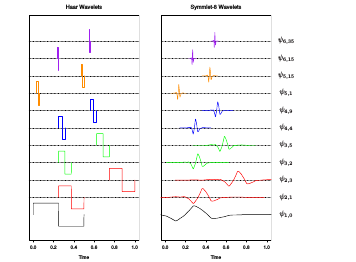

FIG.16. Some selected wavelets at different translations and dilations for the Haar and symmlet families. The functions have been scaled to suit the display.

Wavelets typically use a complete orthonormal basis to represent functions, but then shrink and select the coefficients toward a sparse representation. Just as a smooth function can be represented by a few spline basis functions, a mostly flat function with a few isolated bumps can be represented with a few (bumpy) basis functions. Wavelet bases are very popular in signal processing and compression, since they are able to represent both smooth and/or locally bumpy functions in an efficient way—a phenomenon dubbed time and frequency localization. In contrast, the traditional Fourier basis allows only frequency localization.

Before we give details, let’s look at the Haar wavelets in the left panel of Figure 5.16 to get an intuitive idea of how wavelet smoothing works. The vertical axis indicates the scale (frequency) of the wavelets, from low scale at the bottom to high scale at the top. At each scale the wavelets are “packed in” side-by-side to completely fill the time axis: we have only shown a selected subset. Wavelet smoothing fits the coefficients for this basis by least squares, and then thresholds (discards, filters) the smaller coefficients. Since there are many basis functions at each scale, it can use bases where it needs them and discard the ones it does not need, to achieve time and frequency localization. The Haar wavelets are simple to understand, but not smooth enough for most purposes. The symmlet wavelets in the right panel of Figure 5.16 have the same orthonormal properties, but are smoother.

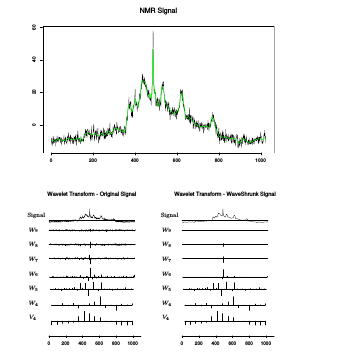

FIG.17 displays an NMR (nuclear magnetic resonance) signal, which appears to be composed of smooth components and isolated spikes, plus some noise. The wavelet transform, using a symmlet basis, is shown in the lower left panel. The wavelet coefficients are arranged in rows, from lowest scale at the bottom, to highest scale at the top. The length of each line segment indicates the size of the coefficient. The bottom right panel shows the wavelet coefficients after they have been thresholded. The threshold procedure, given below in equation (5.69), is the same soft-thresholding rule that arises in the lasso procedure for linear regression (Section 3.4.2). Notice that many of the smaller coefficients have been set to zero. The green curve in the top panel shows the back-transform of the thresholded coefficients: this is the smoothed version of the original signal. In the next section we give the details of this process, including the construction of wavelets and the thresholding rule.

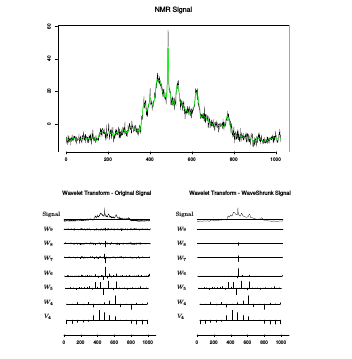

# Wavelet Bases and the Wavelet Transform

Wavelet bases are generated by **translations** and **dilations** of a single **scaling function** $\phi(x)$, also known as the *father wavelet*.

For example, the **Haar basis** uses:
$$
\phi(x) = \mathbb{I}(x \in [0, 1])
$$

The translated versions:
$$
\phi_{0,k}(x) = \phi(x - k), \quad k \in \mathbb{Z}
$$

generate an orthonormal basis for the space $V_0$ of piecewise-constant functions with jumps at the integers.

---

### Multiresolution Spaces

Dilated versions define nested function spaces:
$$
\phi_{j,k}(x) = 2^{j/2} \phi(2^j x - k)
$$

Each $V_j$ is spanned by $\{\phi_{j,k}\}_{k \in \mathbb{Z}}$ and satisfies:
$$
\cdots \supset V_1 \supset V_0 \supset V_{-1} \supset \cdots
$$

Each finer space $V_{j+1}$ includes more detail:
$$
V_{j+1} = V_j \oplus W_j
$$

Here, $W_j$ is the **orthogonal complement** capturing detail at scale $j$.

---

### Analogy to Analysis of Variance (ANOVA)

In ANOVA, two means $\mu_1, \mu_2$ can be decomposed into:
- **Grand Mean**: $\mu = \frac{1}{2}(\mu_1 + \mu_2)$
- **Contrast**: $\alpha = \frac{1}{2}(\mu_1 - \mu_2)$

A small contrast $\alpha$ can be ignored. Similarly, in wavelet transforms, components in $W_j$ with small magnitude may be set to zero to compress the signal.

---

### Wavelet Coefficients and Signal Shrinkage

Given an NMR signal, wavelet decomposition down to $V_4$ reveals multiple subspaces:

- **Detail subspaces**: $W_9, W_8, \dots, W_4$
- **Approximation**: $V_4$

After performing the **discrete wavelet transform**, coefficients are modified using shrinkage (e.g., **SureShrink** in S-PLUS). This removes small components assumed to be noise.

---

**Fig.17 Summary:**

- **Top Panel**: Original and wavelet-shrunk NMR signal.
- **Lower Left**: Wavelet transform (coefficients for $W_9 \to W_4$, $V_4$) using symmlet-8 basis.
- **Lower Right**: Same coefficients after applying shrinkage.

Each coefficient is visualized as a vertical bar, indicating its magnitude and sign.

---

This method enables efficient signal compression and denoising while preserving important structure.


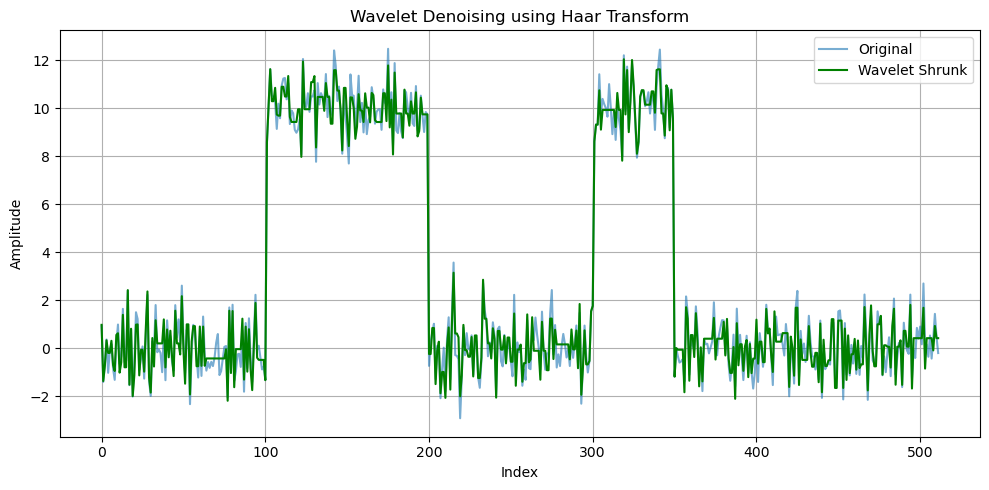

In [5]:
import matplotlib.pyplot as plt

# Discrete Haar Transform (1 level)
def haar_transform(signal):
    approx = []
    detail = []
    for i in range(0, len(signal), 2):
        avg = (signal[i] + signal[i+1]) / 2
        diff = (signal[i] - signal[i+1]) / 2
        approx.append(avg)
        detail.append(diff)
    return approx, detail

# Inverse Haar Transform (1 level)
def inverse_haar_transform(approx, detail):
    signal = []
    for a, d in zip(approx, detail):
        signal.append(a + d)
        signal.append(a - d)
    return signal

# Recursive multi-level decomposition
def multi_level_decompose(signal, levels):
    coeffs = []
    current = signal
    for _ in range(levels):
        current, detail = haar_transform(current)
        coeffs.append(detail)
    coeffs.append(current)  # final approximation
    return coeffs[::-1]  # from coarse to fine

# Reconstruct signal from wavelet coefficients
def multi_level_reconstruct(coeffs):
    current = coeffs[0]
    for detail in coeffs[1:]:
        current = inverse_haar_transform(current, detail)
    return current

# Simple thresholding (shrinkage)
def threshold_coeffs(coeffs, threshold):
    result = [coeffs[0]]  # keep approximation
    for detail in coeffs[1:]:
        shrunk = [d if abs(d) >= threshold else 0 for d in detail]
        result.append(shrunk)
    return result

# Generate synthetic signal (e.g. with noise)
import random
random.seed(0)
signal = [random.gauss(0, 1) + 10 * ((100 < i < 200) or (300 < i < 350)) for i in range(512)]

# Wavelet decomposition
levels = 4
coeffs = multi_level_decompose(signal, levels)

# Shrink small details
shrunk_coeffs = threshold_coeffs(coeffs, threshold=0.5)

# Reconstruction
reconstructed = multi_level_reconstruct(coeffs)
shrunk_signal = multi_level_reconstruct(shrunk_coeffs)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(signal, label='Original', alpha=0.6)
plt.plot(shrunk_signal, label='Wavelet Shrunk', color='green')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Wavelet Denoising using Haar Transform')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


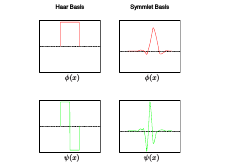
FIG.18. The Haar and symmlet father (scaling) wavelet φ(x) and mother wavelet ψ(x).

# 5.9.2 Haar and Symmlet Wavelet Bases

Wavelet bases are constructed by **translations and dilations** of a single *scaling function* $\phi(x)$ and its corresponding *wavelet function* $\psi(x)$. These functions form the building blocks for multi-resolution analysis.

---

## Haar Basis

- **Scaling function (father wavelet)**:
  $$
  \phi(x) = \mathbb{I}(x \in [0, 1])
  $$

- The set $\{\phi_{0,k}(x) = \phi(x - k)\}_{k \in \mathbb{Z}}$ forms an orthonormal basis for $V_0$.

- **Dilation**:
  $$
  \phi_{j,k}(x) = 2^{j/2} \phi(2^j x - k)
  $$

- **Wavelet function (mother wavelet)**:
  $$
  \psi(x) = \phi(2x) - \phi(2x - 1)
  $$

- The set $\{\psi_{j,k}(x) = 2^{j/2} \psi(2^j x - k)\}$ forms a basis for the detail space $W_j$.

- The nested space decomposition:
  $$
  V_{j+1} = V_j \oplus W_j = V_{j-1} \oplus W_{j-1} \oplus W_j
  $$

- In general:
  $$
  V_J = V_0 \oplus W_0 \oplus W_1 \oplus \cdots \oplus W_{J-1}
  $$

---

## Symmlet-p Basis (e.g., Daubechies Symmlet-8)

- Symmlet wavelets are smoother than Haar but have wider **support**.

- **Support length**: $2p - 1$ intervals. For example, Symmlet-8 covers 15 intervals.

- **Vanishing Moments**:
  $$
  \int \psi(x) x^j dx = 0 \quad \text{for } j = 0, 1, \dots, p - 1
  $$

- This means $V_0$ can reproduce all polynomials up to degree $p - 1$ exactly.

- Haar wavelets have only **1 vanishing moment** and reproduce constants only.

---

## Orthonormal Basis in Discrete Time

If the domain has $N = 2^J$ discrete time points:

- $V_J$ has dimension $2^J$
- The total number of wavelet basis elements is:
  $$
  \sum_{j=0}^{J-1} 2^j = 2^J - 1
  $$

- Plus 1 element in $V_0$, so total = $2^J$

---

## Filter Bank Representation

- Scaling function in $V_0$:
  $$
  \phi(x) = \sum_{k \in \mathbb{Z}} h(k) \phi_{1,k}(x)
  $$

- Wavelet function in $W_0$:
  $$
  \psi(x) = \sum_{k \in \mathbb{Z}} g(k) \phi_{1,k}(x) \quad \text{where } g(k) = (-1)^{1 - k} h(1 - k)
  $$

These filter coefficients $\{h(k)\}$ and $\{g(k)\}$ define the **analysis and synthesis** stages of wavelet transforms.

---

The combination of smoothness, vanishing moments, and compact support makes symmlet wavelets powerful tools for signal compression and denoising.


# 5.9.2 Haar and Symmlet Wavelet Bases

Wavelet bases are constructed by **translations and dilations** of a single *scaling function* $\phi(x)$ and its corresponding *wavelet function* $\psi(x)$. These functions form the building blocks for multi-resolution analysis.

---

## Haar Basis

- **Scaling function (father wavelet)**:
  $$
  \phi(x) = \mathbb{I}(x \in [0, 1])
  $$

- The set $\{\phi_{0,k}(x) = \phi(x - k)\}_{k \in \mathbb{Z}}$ forms an orthonormal basis for $V_0$.

- **Dilation**:
  $$
  \phi_{j,k}(x) = 2^{j/2} \phi(2^j x - k)
  $$

- **Wavelet function (mother wavelet)**:
  $$
  \psi(x) = \phi(2x) - \phi(2x - 1)
  $$

- The set $\{\psi_{j,k}(x) = 2^{j/2} \psi(2^j x - k)\}$ forms a basis for the detail space $W_j$.

- The nested space decomposition:
  $$
  V_{j+1} = V_j \oplus W_j = V_{j-1} \oplus W_{j-1} \oplus W_j
  $$

- In general:
  $$
  V_J = V_0 \oplus W_0 \oplus W_1 \oplus \cdots \oplus W_{J-1}
  $$

---

## Symmlet-p Basis (e.g., Daubechies Symmlet-8)

- Symmlet wavelets are smoother than Haar but have wider **support**.

- **Support length**: $2p - 1$ intervals. For example, Symmlet-8 covers 15 intervals.

- **Vanishing Moments**:
  $$
  \int \psi(x) x^j dx = 0 \quad \text{for } j = 0, 1, \dots, p - 1
  $$

- This means $V_0$ can reproduce all polynomials up to degree $p - 1$ exactly.

- Haar wavelets have only **1 vanishing moment** and reproduce constants only.

---

## Orthonormal Basis in Discrete Time

If the domain has $N = 2^J$ discrete time points:

- $V_J$ has dimension $2^J$
- The total number of wavelet basis elements is:
  $$
  \sum_{j=0}^{J-1} 2^j = 2^J - 1
  $$

- Plus 1 element in $V_0$, so total = $2^J$

---

## Filter Bank Representation

- Scaling function in $V_0$:
  $$
  \phi(x) = \sum_{k \in \mathbb{Z}} h(k) \phi_{1,k}(x)
  $$

- Wavelet function in $W_0$:
  $$
  \psi(x) = \sum_{k \in \mathbb{Z}} g(k) \phi_{1,k}(x) \quad \text{where } g(k) = (-1)^{1 - k} h(1 - k)
  $$

These filter coefficients $\{h(k)\}$ and $\{g(k)\}$ define the **analysis and synthesis** stages of wavelet transforms.

---

The combination of smoothness, vanishing moments, and compact support makes symmlet wavelets powerful tools for signal compression and denoising.


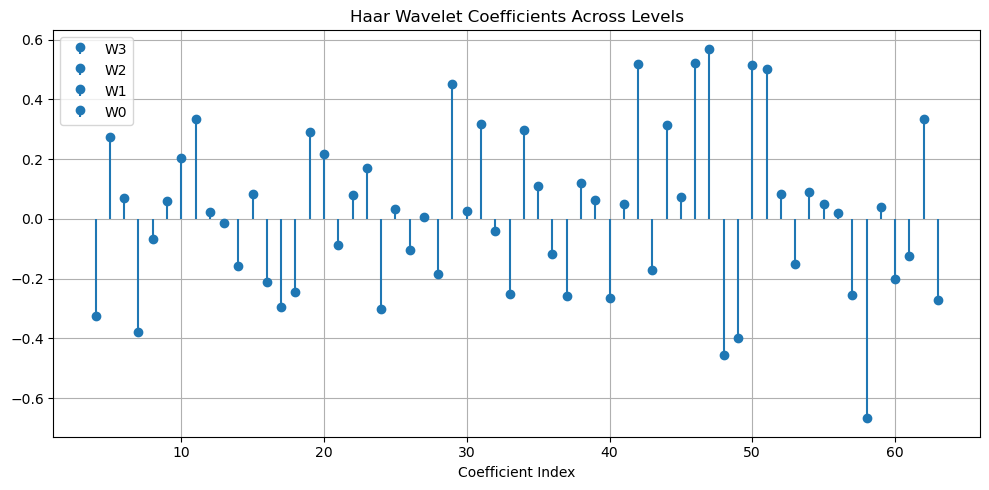

In [6]:
import matplotlib.pyplot as plt
import math
import random

# Generate synthetic signal of length N = 2^J
def generate_signal(length=64):
    return [5 + math.sin(2 * math.pi * i / length) + 0.5 * random.gauss(0, 1) for i in range(length)]

# One-level Haar transform
def haar_transform(signal):
    approx = []
    detail = []
    for i in range(0, len(signal), 2):
        avg = (signal[i] + signal[i+1]) / 2
        diff = (signal[i] - signal[i+1]) / 2
        approx.append(avg)
        detail.append(diff)
    return approx, detail

# Recursive decomposition
def multilevel_haar_decompose(signal, levels):
    coefficients = []
    current = signal[:]
    for _ in range(levels):
        current, detail = haar_transform(current)
        coefficients.append(detail)
    coefficients.append(current)  # final approximation
    return coefficients[::-1]

# Recursive reconstruction
def haar_reconstruct(approx, details):
    current = approx
    for detail in details:
        current = inverse_haar(current, detail)
    return current

def inverse_haar(approx, detail):
    signal = []
    for a, d in zip(approx, detail):
        signal.append(a + d)
        signal.append(a - d)
    return signal

# Plot coefficients across levels
def plot_wavelet_coeffs(coeffs):
    plt.figure(figsize=(10, 5))
    for i, level in enumerate(coeffs[1:]):  # skip V0 approx
        offset = sum([len(c) for c in coeffs[:i+1]])
        x = list(range(offset, offset + len(level)))
        plt.stem(x, level, label=f"W{len(coeffs)-2 - i}", linefmt='C0-', markerfmt='C0o', basefmt=" ")
    plt.title("Haar Wavelet Coefficients Across Levels")
    plt.xlabel("Coefficient Index")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run it
random.seed(42)
signal = generate_signal(length=64)
coeffs = multilevel_haar_decompose(signal, levels=4)
plot_wavelet_coeffs(coeffs)


# 5.9.2 Adaptive Wavelet Filtering

Wavelets are particularly useful when data are measured on a uniform lattice (e.g., signal, image, or time series). We'll focus on the one-dimensional case, where having $N = 2^J$ time points is computationally convenient.

---

## Wavelet Transform

Let:

- $y$ be the signal (response vector)
- $W$ be the $N \times N$ orthonormal wavelet basis matrix

Then the **wavelet transform** of $y$ is:

$$
y^\ast = W^T y
$$

This transformation is equivalent to computing the **least squares coefficients** of $y$ in the wavelet basis.

---

## SURE Shrinkage

The **SURE shrinkage** method (Donoho and Johnstone, 1994) is based on minimizing:

$$
\min_{\theta} \left\| y - W\theta \right\|_2^2 + 2\lambda \|\theta\|_1 \tag{5.68}
$$

Since $W$ is orthonormal, the solution simplifies to soft-thresholding of the wavelet coefficients:

$$
\hat{\theta}_j = \text{sign}(y^\ast_j)\left( |y^\ast_j| - \lambda \right)_+ \tag{5.69}
$$

The **fitted signal** is then obtained by the inverse wavelet transform:

$$
\hat{f} = W \hat{\theta}
$$

---

## Choice of $\lambda$

A simple threshold is:

$$
\lambda = \sigma \sqrt{2 \log N}
$$

where $\sigma$ is an estimate of the noise standard deviation.

This choice is motivated by the expected maximum of $N$ independent $\mathcal{N}(0, \sigma^2)$ random variables:

$$
\mathbb{E}\left[ \max_j |Z_j| \right] \approx \sigma \sqrt{2 \log N}
$$

---

## Key Characteristics of Wavelet Bases

- Localized in **time** (translations of basis functions)
- Localized in **frequency** (each scale spans an octave)
- Enables **sparse representations** for signals with localized spikes

---

## Comparison: SURE Shrinkage vs. Smoothing Splines

| Property                         | Wavelets (SURE)                    | Smoothing Splines                   |
|----------------------------------|------------------------------------|-------------------------------------|
| Penalty Type                    | $\ell_1$ (shrinkage + selection)   | $\ell_2$ (pure shrinkage)           |
| Basis                           | Wavelets (localized + hierarchical)| Natural splines                     |
| Local vs. Global                | Localized in time/frequency        | Global smoothness                   |
| Adaptivity                     | High adaptivity, sparse spikes     | Smooth fits, sometimes over-smooth  |

---

## Computational Efficiency

- Direct matrix form: $y^\ast = W^T y$
- Fast implementation via **pyramidal algorithm**: $\mathcal{O}(N)$ operations
- Faster than FFT ($\mathcal{O}(N \log N)$)

---

Wavelets provide a powerful and flexible tool for adaptive signal estimation, allowing both **compression** and **denoising** via simple thresholding strategies.


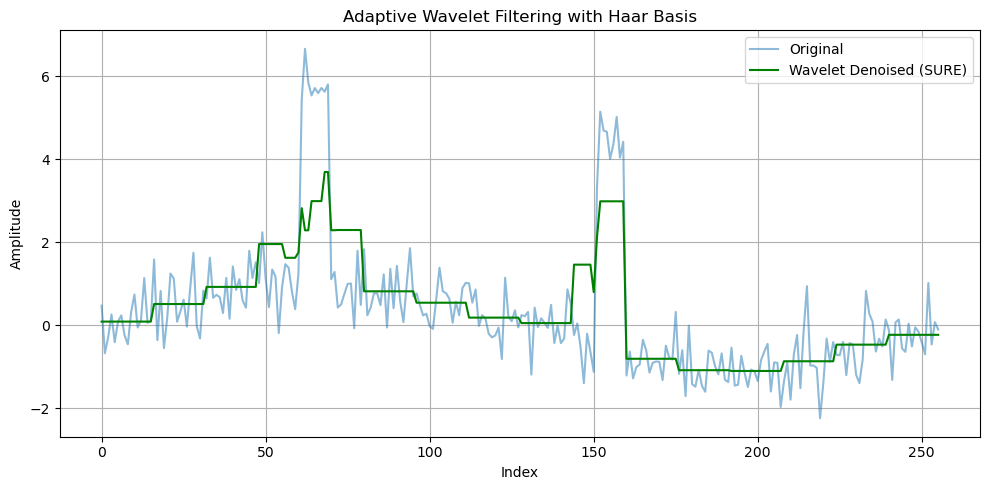

In [7]:
import random
import math
import matplotlib.pyplot as plt

# Generate synthetic signal: a mix of smooth + spikes + noise
def generate_signal(N=256):
    random.seed(0)
    signal = []
    for i in range(N):
        base = math.sin(2 * math.pi * i / N)
        spike = 5 if 60 < i < 70 or 150 < i < 160 else 0
        noise = random.gauss(0, 0.5)
        signal.append(base + spike + noise)
    return signal

# Basic Haar transform (one level)
def haar_transform(signal):
    approx = []
    detail = []
    for i in range(0, len(signal), 2):
        a = (signal[i] + signal[i+1]) / 2
        d = (signal[i] - signal[i+1]) / 2
        approx.append(a)
        detail.append(d)
    return approx, detail

# Inverse Haar transform (one level)
def inverse_haar(approx, detail):
    signal = []
    for a, d in zip(approx, detail):
        signal.append(a + d)
        signal.append(a - d)
    return signal

# Recursive wavelet decomposition
def wavelet_decompose(signal, levels):
    coeffs = []
    current = signal
    for _ in range(levels):
        current, detail = haar_transform(current)
        coeffs.append(detail)
    coeffs.append(current)  # final coarse approximation
    return coeffs[::-1]  # from coarse to fine

# Recursive reconstruction
def wavelet_reconstruct(coeffs):
    current = coeffs[0]
    for detail in coeffs[1:]:
        current = inverse_haar(current, detail)
    return current

# Soft-threshold shrinkage
def soft_threshold(x, lam):
    return [math.copysign(max(abs(v) - lam, 0), v) for v in x]

# Estimate noise level (using finest detail coefficients)
def estimate_lambda(detail_coeffs, N):
    sigma = (sum(d**2 for d in detail_coeffs) / len(detail_coeffs)) ** 0.5
    return sigma * math.sqrt(2 * math.log(N))

# Shrink detail coefficients
def shrink_coeffs(coeffs):
    N = sum(len(c) for c in coeffs)
    finest_detail = coeffs[-1]
    lam = estimate_lambda(finest_detail, N)
    result = [coeffs[0]]  # coarse approx
    for detail in coeffs[1:]:
        result.append(soft_threshold(detail, lam))
    return result

# Full pipeline
signal = generate_signal()
coeffs = wavelet_decompose(signal, levels=4)
shrunk_coeffs = shrink_coeffs(coeffs)
denoised = wavelet_reconstruct(shrunk_coeffs)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(signal, label="Original", alpha=0.5)
plt.plot(denoised, label="Wavelet Denoised (SURE)", color="green")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.title("Adaptive Wavelet Filtering with Haar Basis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
